# Final Project: Analysis of GW200129

For this assignment, you will have to conduct an analysis of the gravitational-wave signal GW200129_065458 (thereafter simply GW200129). This analysis should be done within a Jupyter notebook, with many comments in [Markdown](https://colab.research.google.com/notebooks/markdown_guide.ipynb) desribing and **justifying** the steps taken.

- The writing should be at the level of a fellow student of the class
- Describe **in details** every step of your analysis throughout the notebook.
- Any setting choice (sampling rate, window parameter, FFT length, etc...) needs to be justified, either by its own investigation or relevant citations from the literature.
- Code alone, without a detailed descriptions of what is done and why, is worth at most half marks.
- Remember to re-run your notebook from scratch after a kernel re-start before submission.

NOTE: you can use any of the notebooks covered in the class, or code available online, _provided that you justify the settings and methods used_.

## Introduction (15 points)
Minimum 300 words.
- Write an introduction to this analysis, citing the relevant context and literature.
- Write a short summary of what is done in the notebook.

GW200129 [1], a gravitational wave event detected during LIGO-Virgo's third observational run (O3), presented challenges in parameter inference due to data quality issues. The event’s high signal-to-noise ratio (SNR) led to large discrepancies between various CBC models. Spin-precession inference was particularly difficult because of variations across detectors and different pipelines, with glitches in LIGO’s data exacerbating the problem. Additionally, the Virgo detector reported a low SNR, resulting in an inaccurate mass estimate. This analysis aims to parametrize GW200129 using both coherent and coincident methods, focusing on the impact of the glitch and comparing different CBC models, including SEOBNRv4_opt, in contrast to NRSur7dq4 and IMRPhenomXPHM. The study emphasizes that events like GW200129, dominated by the merger phase and high masses, require careful consideration of both waveform systematics and potential small data quality issues, as these can affect subtle parameter inferences.

In the original analysis of GW200129, different gravitational waveform models were employed to capture the binary coalescence (CBC) dynamics and glitches. The study utilized CBC models alongside a glitch model to characterize the observed waveforms, with post-hoc waveform generation performed by BayesWave [2]. For parameter estimation, the analysis relied on the Bilby framework, which uses Markov Chain Monte Carlo (MCMC) samplers to derive posterior distributions of model parameters. In our approach, we use the PyCBC [3] framework for CBC waveform analysis. The Powell method is utilized as an optimizer for efficient parameter space exploration, while MCMC is again employed for parameter estimation, ensuring a robust exploration of the parameter space. Additionally, a burst model was considered for specific waveform features, further informing the analysis of the signal.

Initially this project will do an initial exploration of the data by plotting both the time series and PSD representations of the signal received at both L1 and H1. The data received at H1 was then matched filtered 'by eye' using two different methods: a waveform generated with the SEOBNRv4_opt CBC model; and a sine-Gaussian. Following this a true coincident match-filter analysis with both models by computing the SNR values of each model. This was done on the H1 data, which had the highest SNR of all detections of ~25. A coincident analysis was then performed with H1 and L1, which allowed for a Bayesian analysis to be performed. The was intitially done with an optimisation of the posterior using the Powell method, generating maximum a postiori parameters. Following this, a true posterior sampling was performed using an MCMC, which allowed for a corner plot of both correlation distribution between each and a posterior distribution of each parameter.

## The data and noise model (10 points)

- Download and plot the relevant gravitational-wave data for GW200129.
- Compute and plot the Power Spectrum Density.
- Compute and plot the whitened data. Use filters if necessary to best highlight where the signal is (or might be).

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
!pip install -q gwpy

In [12]:
! pip install -q lalsuite pycbc

In [13]:
from scipy.signal import get_window

In [14]:
from gwosc.datasets import event_gps

In [15]:
from gwpy.timeseries import TimeSeries

In [16]:
time_centre = event_gps('GW200129_065458')

print(time_centre)

1264316116.4


In [17]:
GW_200129_strain_H1 = TimeSeries.fetch_open_data('H1', time_centre-512, time_centre+512) #fetches the time series from H1
GW_200129_strain_L1 = TimeSeries.fetch_open_data('L1', time_centre-512, time_centre+512) #fetches the time series from L1

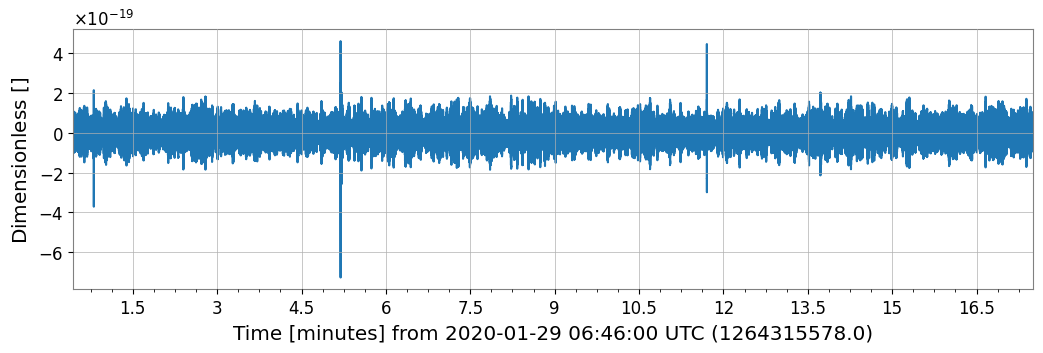

In [18]:
H1_strain = GW_200129_strain_H1.plot()

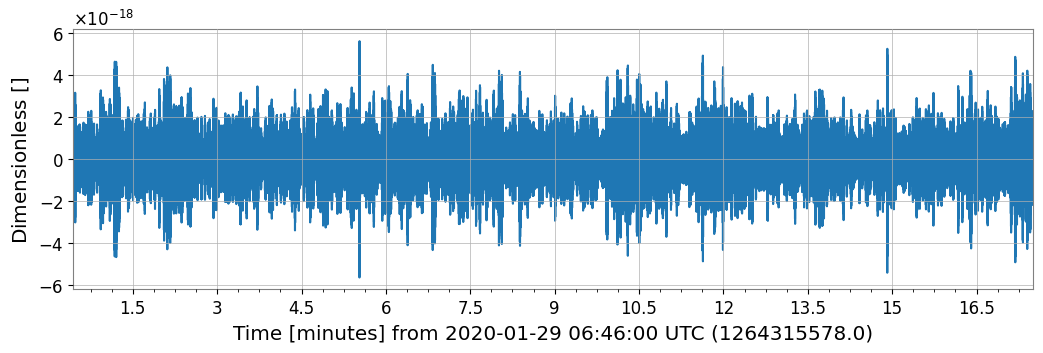

In [19]:
L1_strain = GW_200129_strain_L1.plot()

In [20]:
normalised_fft=GW_200129_strain_H1.average_fft(window=('tukey',1./4.))*(GW_200129_strain_H1.duration.value/2)

/usr/local/lib/python3.11/dist-packages/gwpy/plot/axes.py:194: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  super().draw(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


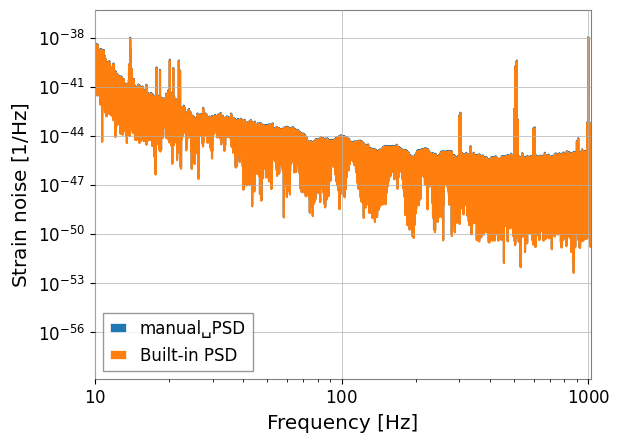

In [21]:
plt.loglog((2/GW_200129_strain_H1.duration.value)*np.abs(normalised_fft)**2,label='manual␣PSD')
plt.loglog(GW_200129_strain_H1.psd(window=('tukey',1./4.)),label='Built-in PSD')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.xlim(10,1024)
plt.legend();

In [22]:

strain_H1_white = GW_200129_strain_H1.whiten(fftlength=4,overlap=2,window=('tukey',1./4.))
# Getting a more manageable 32 seconds of data:
strain_white=strain_H1_white.crop(time_centre - 16,time_centre+ 16)


Text(0.5, 0, 'time [s]')

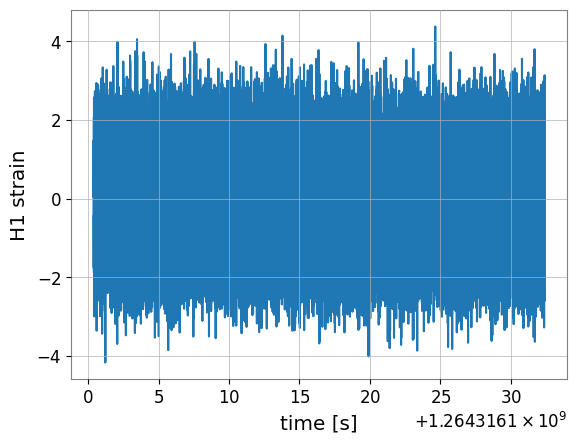

In [23]:
plt.plot(strain_white)
#plt.xlim(gps+0.25,gps+0.46)
plt.ylabel('H1 strain')
plt.xlabel('time [s]')

'The rate of glitches at frequencies similar to the signal is much lower; using data from 4 days around the event, the rate of glitches with frequency 60-120 Hz is only 0.06/hr.'

In [24]:
# Badpassing the whitened strain with specific values are defined in the detection paper (will look up lol)
strain_bp=strain_white.bandpass(60.,120.)

Text(0.5, 0, 'time [s]')

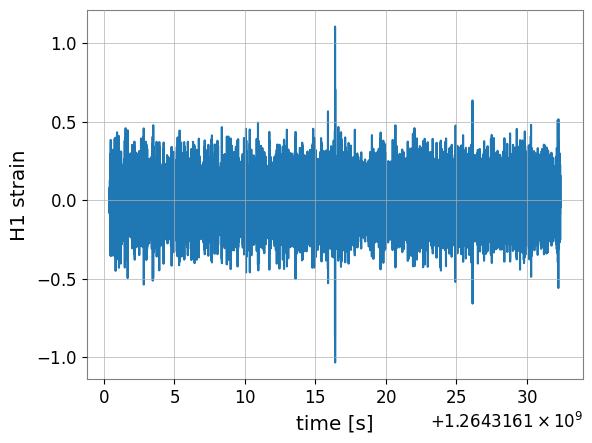

In [25]:


plt.plot(strain_bp)
#plt.xlim(gps+0.15,gps-0.05)
plt.ylabel('H1 strain')
plt.xlabel('time [s]')




Obvious peak present after band passing

Text(0.5, 0, 'time [s]')

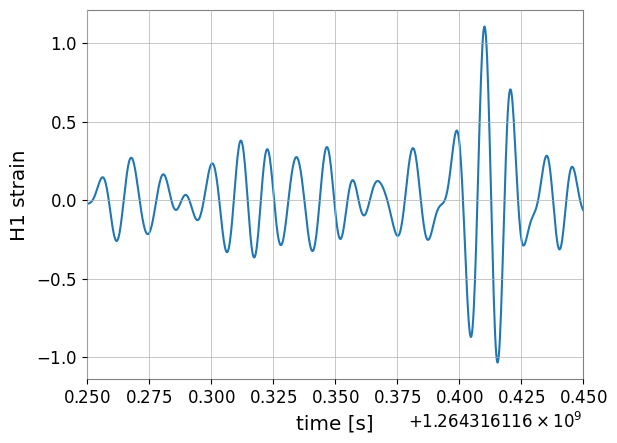

In [26]:
plt.plot(strain_bp)
plt.xlim(time_centre-0.15,time_centre+0.05)
plt.ylabel('H1 strain')
plt.xlabel('time [s]')

## The signal model (10 points)

- Generate and plot a CBC signal which you expect to be a good match for the signal. Use the literature, and cite your sources
- Generate and plot a phenomenological model (sometimes refer to as a "Burst" model). A model whose parameters describe the shape of the waveform itself, not the source.
- Plot those those two signals together, and try to find _by eye_ parameters that maximises that overlap. Discuss.

NOTE: remember that gravitational-wave are redshifted.

In [27]:
import pycbc
from pycbc.waveform import get_td_waveform

In [28]:
strain_bp=strain_white.bandpass(60.,120.).crop(time_centre-0.15,time_centre+0.05)

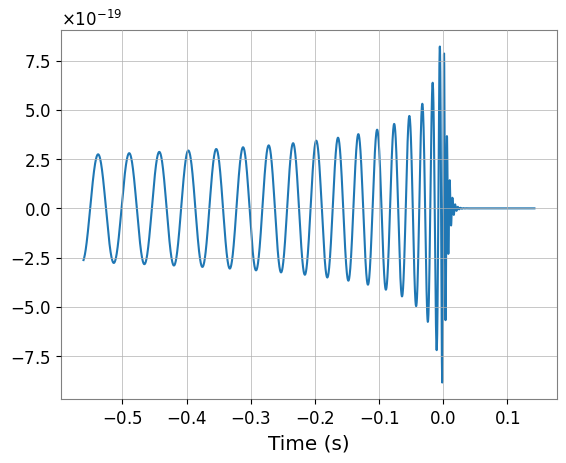

In [29]:
'''
I could definitely add distance
'''
m1 = 34.5 * (1 + 0.18)
m2 = 29 * (1 + 0.18)
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
mass1=m1,
mass2=m2,
delta_t=1./GW_200129_strain_H1.sample_rate.to_value(),
f_lower=20)

plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)');

#hp.start_time = gps + 0.01

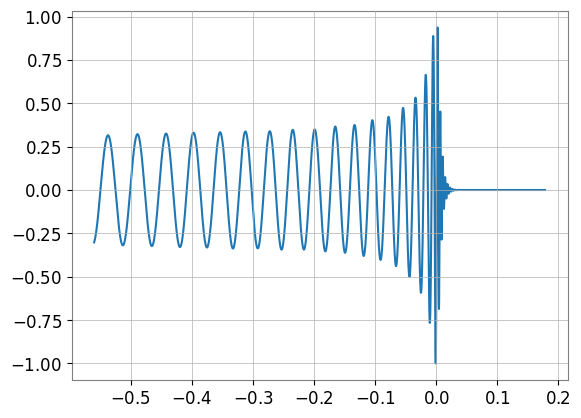

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform

# Define masses with correction factor
m1 = 34.5 * (1 + 0.18)
m2 = 29 * (1 + 0.18)

# Define sample rate (ensure GW_200129_strain_H1.sample_rate is defined)
delta_t = 1. / GW_200129_strain_H1.sample_rate.to_value()

# Generate waveform
hp, hc = get_td_waveform(approximant="SEOBNRv4PHM",
                          mass1=m1,
                          mass2=m2,
                          delta_t=delta_t,
                          spin1x=0.9,
                          f_lower=20)

# Find the current peak strain (you could adjust this to your expected peak)
# Convert hp to a NumPy array before calling np.max
current_peak = np.max(np.abs(hp.numpy()))


# Define the desired peak strain (e.g., we want it to be 1)
desired_peak = 1.0

# Calculate the scaling factor
scaling_factor = desired_peak / current_peak

# Apply the scaling factor to the waveform
hp_scaled = hp * scaling_factor

# Plot the scaled waveform
plt.plot(hp.sample_times, hp_scaled)

hp.start_time = time_centre - 0.545

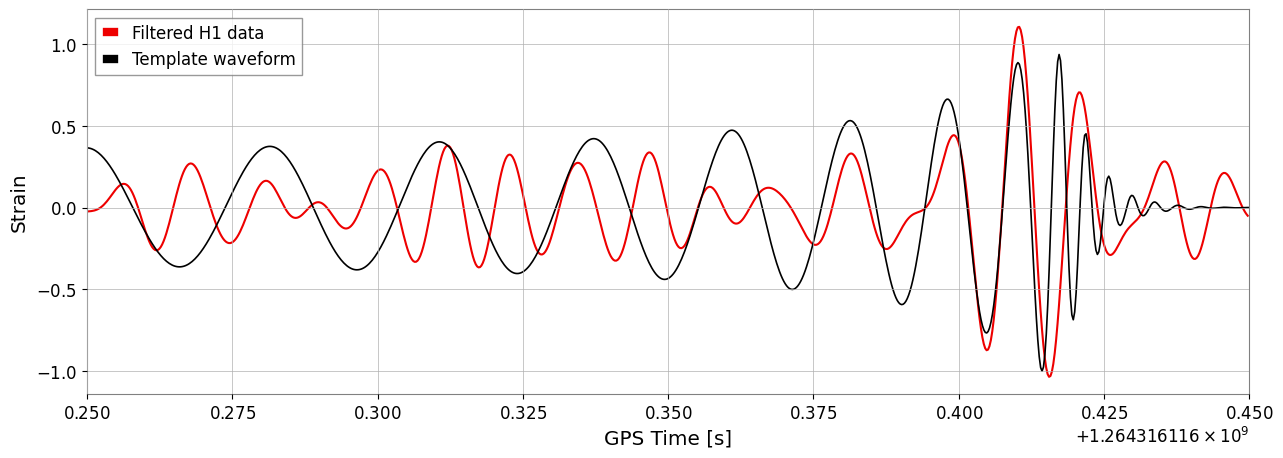

In [31]:
plt.figure(figsize=(15,5))
plt.plot(strain_bp.times,strain_bp,label='Filtered H1 data', color='gwpy:ligo-hanford')
#plt.plot(hp.sample_times,hp,label='template')
plt.plot(hp.sample_times, hp_scaled, label='Template waveform', color='black', linewidth=1.2)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.xlim(time_centre-0.15,time_centre+0.05)
#plt.ylim(-5e-22, 5e-22)
plt.legend()



Above is a waveform I've scaled up to fit to the data. Idk if I'm even suppsoed to do this


In [32]:
print(f"Waveform duration: {hp.duration:.3f} s")

Waveform duration: 0.739 s


In [33]:
from scipy.signal import gausspulse

In [34]:
t0 = hp.sample_times[np.argmax(np.abs(hp))] # gives time hp reaches maximum value

In [35]:
time_shifted = hp.sample_times - t0 #shifts gaussian to the right time

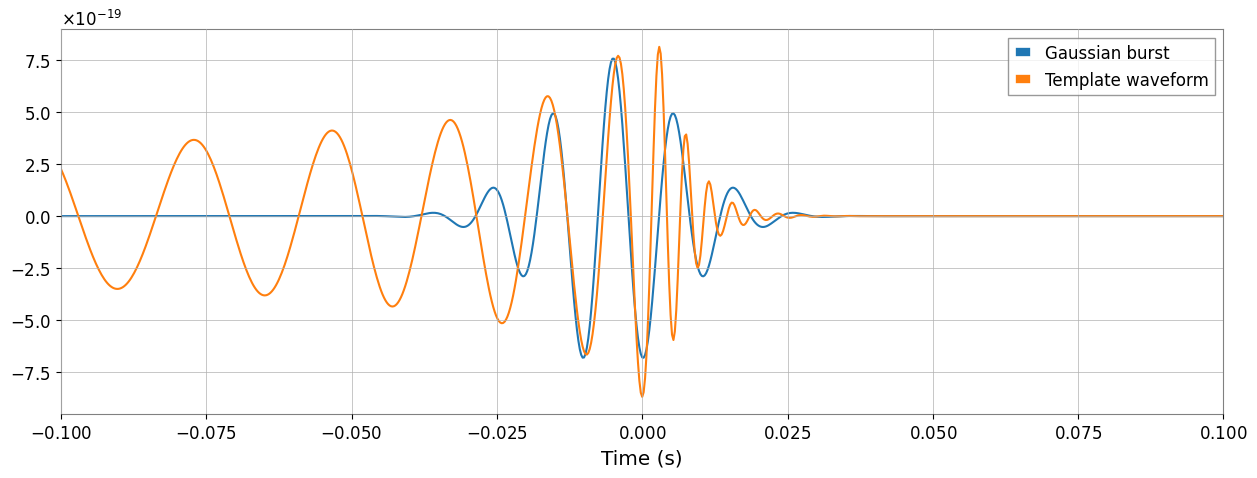

In [36]:
plt.figure(figsize=(15, 5))
plt.plot(time_shifted, gausspulse(time_shifted + 0.005, fc=95, bw=0.35)*7.6e-19, label='Gaussian burst')
plt.plot(time_shifted, hp, label='Template waveform')
plt.xlabel('Time (s)')
plt.legend()
plt.xlim(-0.1, 0.1)
plt.show()

## Detection (25 points)
Limiting yourself to a coincident (**not** coherent) analysis:
- Compute the SNR time series for the CBC signal model
- Compute the SNR time series for the Burst signal model
- Discuss the differences, if any.
- Estimate a bound on the False Alarm Rate of the detection.

In [37]:

strain_H1 = TimeSeries.fetch_open_data('H1', time_centre - 16, time_centre +16)

Strain is limited to 16 seconds are the time centre of the signal.

In [38]:
Pxx_H1=strain_H1.psd(fftlength=4.,window=('tukey',1./4.),method='welch',overlap=2.)

For the fast fourier transformer to calculate the PSD of the signal, four hyperparameters were selected.

A Fast Fourier Transform (FFT) length of 4 seconds results in a frequency resolution of 0.25 Hz, meaning the power spectral density (PSD) is computed in discrete bins spaced 0.25 Hz apart. This allows for the detection of small frequency variations while keeping computational efficiency manageable. Spectral leakage can occur when signal frequencies do not align perfectly with these bins, causing energy to spread into neighboring bins. To mitigate this, a Tukey window is applied.

The Tukey window reduces spectral leakage by tapering the edges of each segment before applying the FFT. The tapering is controlled by the shape parameter (1/4), which determines the balance between a Hann-like window (stronger tapering, less leakage) and a rectangular window (no tapering, sharper spectral resolution but more leakage). A value of 1/4 provides a good trade-off between reducing spectral leakage and maintaining frequency resolution.

The overlap setting controls how much adjacent FFT segments overlap in time when using Welch’s method to estimate the PSD. A higher overlap smooths the PSD by reducing statistical variance, improving stability without affecting frequency resolution.

The high sample rate of 4096Hz gives a Nyquist frequency of 2048Hz, which is the highest frequency we're able to analyse. This allows for a high fft length of 4, which gives a good enough spectral resolution to detec

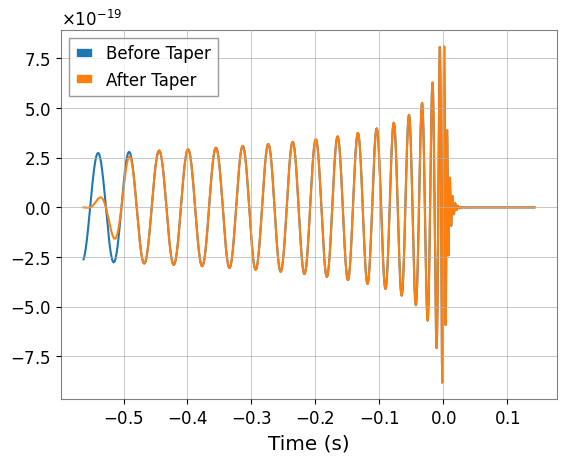

In [39]:
m1 = 34.5*1.18 # Solar masses
m2 = 28.9*1.18 # Solar masses

h_plus, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m1,
                     mass2=m2,
                     delta_t=strain_H1.dt.value,
                     f_lower=20)

plt.plot(h_plus.sample_times, h_plus,label='Before Taper')
plt.plot(h_plus.sample_times, h_plus*get_window(('tukey',1/4),h_plus.shape[0]),label='After Taper')
plt.xlabel('Time (s)')
plt.legend()

The tukey window was also applied to the generated waveform. This is important for calculating the correct SNR.:

In [40]:
strain_white = strain_H1.whiten(fftlength=4,overlap=2,window=('tukey',1./4.))

The strain is then whitened using the same hyperparameters as the PSD calculation, since it also requires a calculation of the PSD to be computed. Whitening flattens the spectrum by dividing the signal (which has been fourier transformed) by the square root of the PSD. This step is important by making all frequencies equally weighted, which is important for identifying weaker signals.

In [41]:
#Badpassing the whitened strain with specific values are defined in the detection paper
strain_bp=strain_white.bandpass(60.,120.)

Text(0.5, 0, 'time [s]')

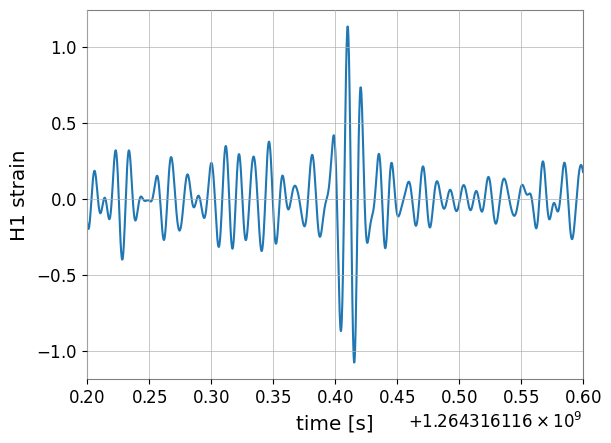

In [42]:
plt.plot(strain_bp)
plt.xlim(time_centre-0.2,time_centre+0.2)
plt.ylabel('H1 strain')
plt.xlabel('time [s]')

In [43]:
# Making it 32 seconds:
h_plus.prepend_zeros(np.ceil((16+h_plus.start_time)/h_plus.delta_t))
h_plus.append_zeros(np.floor((16-h_plus.end_time)/h_plus.delta_t))

template=TimeSeries.from_pycbc(h_plus)
template.duration

<Quantity 32. s>

The generated waveform is padded with zeros to allow it to be 32 seconds, which is the length of the cropped data.

In [44]:
# Same with the data:
strain_H1_32=strain_H1.crop(time_centre - 16,time_centre + 16)

/usr/local/lib/python3.11/dist-packages/gwpy/types/series.py:991: UserWarning: TimeSeries.crop given end larger than current end, crop will begin when the Series actually ends.
  warn(


In [45]:
# FFT of the data, with the appropriate normalisation
data_f=strain_H1_32.average_fft(window=('tukey',1./4.))*(strain_H1_32.duration/2)



Cropped data is fourier transformed and normalised with the duration of the signal divided by two.

Normalization ensures that the Fourier Transform (FFT) output has the correct physical meaning and units. Without proper normalization, the power spectral density (PSD) or any further analysis based on the FFT would be incorrectly scaled


In [46]:
# FFT of the template, with the appropriate normalisation
template_f=template.average_fft(window=('tukey',1./4.))*(template.duration/2)

In [47]:
# We will need the PSD with the same frequency spacing as the data and template,
# so we interpolate it to match:
Pxx_H1_32=Pxx_H1.interpolate(data_f.df.value)

In [48]:
# With the right normalisation, this is equation 7.58 of the textbook:
optimal=data_f*template_f.conjugate()/Pxx_H1_32
opt_time=2*optimal.ifft()*(optimal.df*2)

In [49]:
# This is equation 7.49 of the textbook: the overlap of the template with itself
sigmasq = 4 * np.real((template_f * template_f.conjugate() / Pxx_H1_32).sum() * template_f.df)
sigma = np.sqrt(np.abs(sigmasq))

# And now we have the SNR time series:
SNR_complex = opt_time/sigma

In [50]:
# We can recenter thing with the location of peak in the template:
peaksample = template.argmax()
SNR_complex = np.roll(SNR_complex,peaksample)
SNR = abs(SNR_complex)

In [51]:
SNRmax=SNR.max().value
time_max=SNR.times[SNR.argmax()]
print('Maximum SNR of {} at {}.'.format(SNRmax,time_max))

Maximum SNR of 14.985305275454742 at 1264316116.4235837 s.


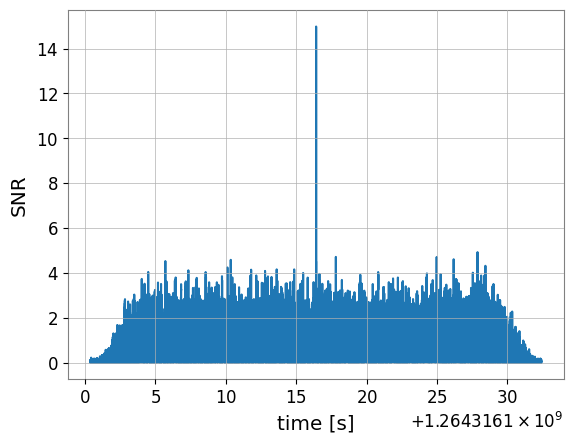

In [52]:
plt.plot(SNR.times,SNR)
plt.xlabel('time [s]')
plt.ylabel('SNR');

In [53]:
duration = strain_H1_32.duration.value  # Should be 32 seconds
print(duration)

32.0


In [54]:
dt = strain_H1_32.dt.value  # Sample spacing

In [55]:
t = np.arange(-duration / 2, duration / 2, dt)

In [56]:
print(f"t min: {t.min()}, t max: {t.max()}, dt: {dt}, length: {len(t)}") #shows the bounds we need for the match filtering at 2048Hz


t min: -16.0, t max: 15.999755859375, dt: 0.000244140625, length: 131072


Gausspulse was not allowing me to generate a waveform with these constraints, so I generated my own waveform.\

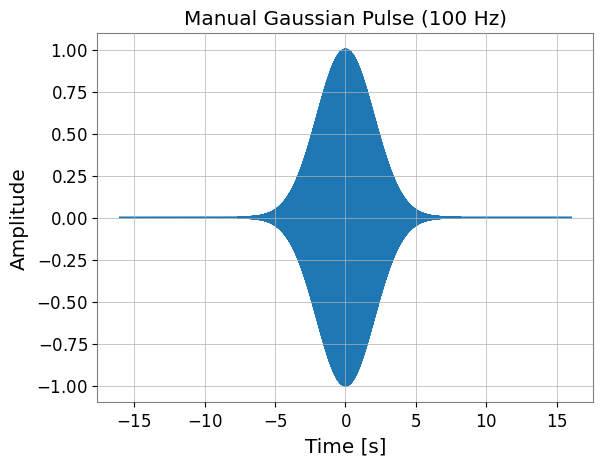

Max pulse value: 0.9999287234784653, Min: -0.9999287234784653


In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Define the time array (16 seconds centered at 0)
t = np.arange(-16, 16, 0.000244140625)

# Frequency and standard deviation for the Gaussian
fc = 95  # 100 Hz center frequency
sigma = 2  # Adjust the Gaussian width

# Generate the Gaussian-modulated sine wave
gaussian_pulse_manual = np.exp(-t**2 / (2 * sigma**2)) * np.sin(2 * np.pi * fc * t)

# Plot the result
plt.plot(t, gaussian_pulse_manual)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Manual Gaussian Pulse (100 Hz)")
plt.show()

# Check if the pulse has non-zero values
print(f"Max pulse value: {np.max(gaussian_pulse_manual)}, Min: {np.min(gaussian_pulse_manual)}")

Pulse is constrained between -16 and 16 seconds, with a dt of 0.000244140625s.

In [58]:
from gwpy.timeseries import TimeSeries

# Convert to TimeSeries (use the same sample rate as strain_H1)
gaussian_pulse_series = TimeSeries(gaussian_pulse_manual, dt=strain_H1.dt.value)
gaussian_pulse_series *= 7.6e-19  # Scale up to match GW strain levels


#gaussian_pulse_series = np.nan_to_num(gaussian_pulse_series, nan=0.0)


#gaussian_pulse_series = np.max(np.abs(gaussian_pulse_series))  # Normalize
#gaussian_pulse_series *= 1e21  # Scale up to match GW strain levels


In [59]:
gaussian_white = gaussian_pulse_series.whiten(fftlength=4, overlap=2, window=('tukey', 1./4.))

Whitens the gausspulse series in the same way previously discussed

In [60]:
gaussian_f = gaussian_white.average_fft(window=('tukey', 1./4.)) * (gaussian_white.duration / 2)


In [61]:
# Ensure PSD matches the frequency resolution
Pxx_H1_interp = Pxx_H1.interpolate(gaussian_f.df.value)

# Compute the matched filter SNR
optimal_gaussian = strain_H1_32.average_fft(window=('tukey', 1./4.)) * gaussian_f.conjugate() / Pxx_H1_interp
opt_time_gaussian = 2 * optimal_gaussian.ifft() * (optimal_gaussian.df * 2)

# Compute sigma^2 (Equation 7.49)
sigma_sq_gaussian = 4 * np.real((gaussian_f * gaussian_f.conjugate() / Pxx_H1_interp).sum() * gaussian_f.df)
sigma_gaussian = np.sqrt(np.abs(sigma_sq_gaussian))

# Final SNR time series
SNR_gaussian = opt_time_gaussian / sigma_gaussian


Maximum SNR for Gaussian Pulse: 0.22737325259048688 at 1264316109.9592283 s s.


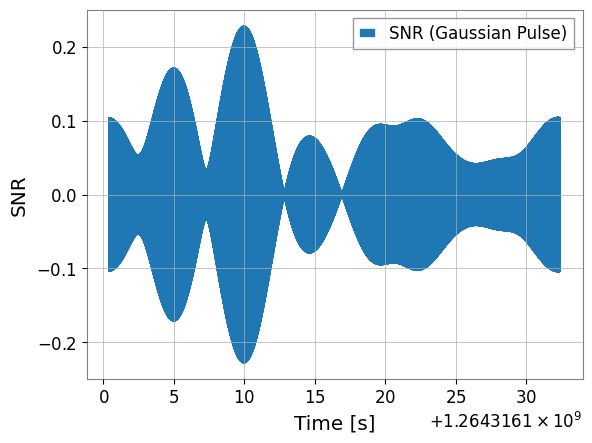

In [62]:
SNRmax_gaussian = SNR_gaussian.max().value
time_max_gaussian = SNR_gaussian.times[SNR_gaussian.argmax()]

print(f"Maximum SNR for Gaussian Pulse: {SNRmax_gaussian} at {time_max_gaussian} s.")

plt.plot(SNR_gaussian.times, SNR_gaussian, label="SNR (Gaussian Pulse)")
plt.xlabel("Time [s]")
plt.ylabel("SNR")
plt.legend()
plt.show()


The SNR calculated using the CBC method was 14.99, which is an appopriate value which indicates a high likelihood of detection (which will be confirmed statistically later). Conversely, the burst method failed in determining any sort of signal within the noise, with a value of 0.22.

There are numerous reason for this, one being the allowance of the CBC model to account for parameters intinsic to the system. The prior knowledge of knowing that the signal's origin is a BBH merger, and furthermore the mass and redshift parameters are beneficial in modelling the signal. In comparison, the only parameters which can be altered using the burst method are the central frequency and bandwidth which makes it quite difficult to accurately match filter the signal. The fundamental nature of the signal being a CBC instead of a burst also leads to difficulty, since the sine gaussian does not accurately capture the long terms portions of the signal such as the inspiral phase.

To conlcude, the pulse seems to be a far too simplistic model to accurately match filter the signal.

The true SNR was ~25. The disrepency may be due to the model chosen for the CBC. NRSur7dq4 seemed to give the most accurate value for the SNR, however I could not get this to work :(.

Comparing the Methods:

    Matched Filtering for CBC (SNR ~ 15):

        SNR of 15 is a solid detection, and it's a result of using template waveforms that match the CBC signal well. This is the state-of-the-art technique for detecting known gravitational wave signals, and it works well even in noisy data.

    Gaussian Pulse (Low SNR):

        A single Gaussian pulse is much simpler and doesn't model the complexity of gravitational waves from compact binaries. The SNR will naturally be low, especially if the Gaussian pulse doesn't match the signal well.

Conclusion:

The Matched Filtering method for CBCs is indeed superior and much more reliable for gravitational wave detection because it uses templates that capture the specific waveform from binary mergers. A SNR of 15 is considered excellent for a CBC detection.

In contrast, using a Gaussian pulse is a simplified approximation and doesn't capture the full complexity of CBC signals, which is why the SNR is lower in that case.

## Parameter Estimation (25 points)
Moving to a **coherent** analysis:
- Using the CBC model, build likelihood, prior and posterior functions for the network of gravitational-wave detectors.
- Maximise the likelihood function and plot relevant quantities.
- Interface the posterior function with a sampling algorithm.
    - You are free to select any ready-made algorithm, or write your own.
- Perform the sampling, and plot the results.
    -  This step can take a long time, and so it is best to develop and test first with a few sampling iterations, and not with the whole sampling run.
- Compare the results with the literature and discuss.

In [63]:
data={} # an empty dictionary
ifos=['L1','H1'] # a list which we use as the dictionary keys
for ifo in ['H1','L1']:
    data[ifo] = TimeSeries.fetch_open_data(ifo, time_centre - 16, time_centre +16)

In [64]:
# Remove the low frequency content and downsample the data to 2048Hz
for ifo in ['H1','L1']:
    data[ifo] = data[ifo].highpass(15).resample(2048)

GOing to down sample for speed. In the paper, for CBC model parameter estimation, the sampling rate was also down sampled from 4096 Hz to 2048 Hz.

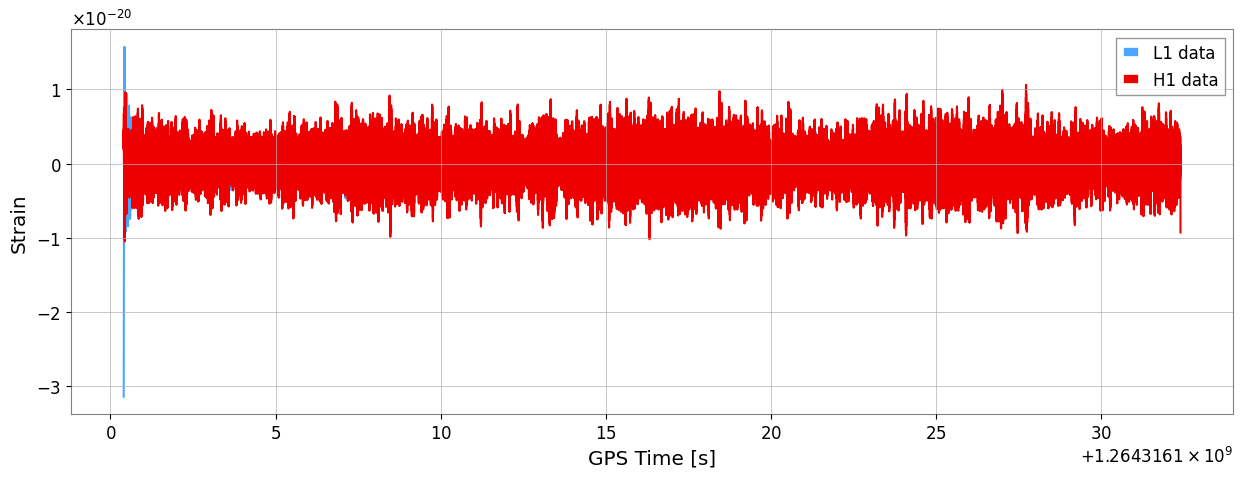

In [65]:
plt.figure(figsize=(15,5))
colours=['gwpy:ligo-livingston','gwpy:ligo-hanford']
for ifo,colour in zip(ifos,colours):
    plt.plot(data[ifo],label='{} data'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();

The waveforms seem fairly similar, with the glitch in L1 as described in the paper being fairly obvious.

In [66]:
psd={}
for ifo in ifos:
    psd[ifo] = data[ifo].psd(fftlength=4)

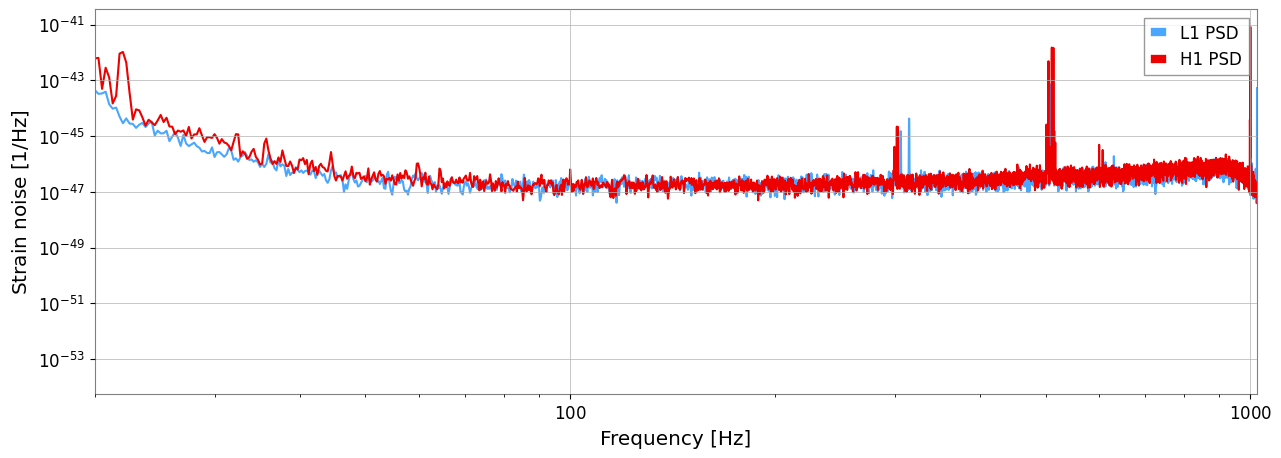

In [67]:

plt.figure(figsize=(15,5))
for ifo,colour in zip(ifos,colours):
    plt.loglog(psd[ifo],label='{} PSD'.format(ifo),color=colour)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.xlim(20,1024)
plt.legend();

PSD for both detectors. Spectral leakage becomes obvious below approximately ~60Hz due to larger variation in strain for each frequency bin. This occurs due to longer wavelength signals being more affected by the truncation applied by FFT when calculating the PSD. This necessitates band passing, since when whitening the data we want to focus on the regions which best represent the signal.

Waveform systematics are expected to play a significant role in GW200129’s inference (e.g. Refs. [1, 14, 101]), which motivates utilizing NRSur7dq4 for all of our main text results.

It does not work :(

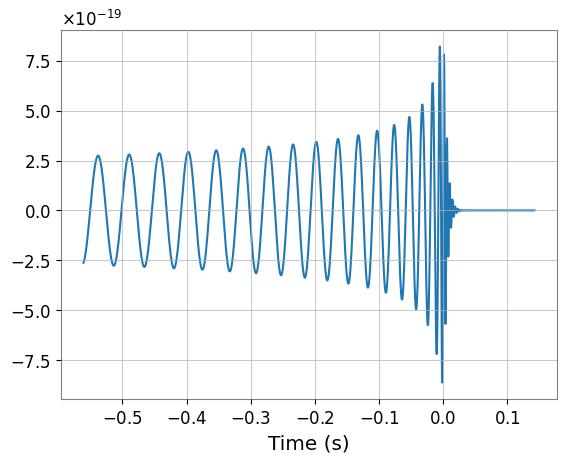

In [68]:
m1 = 34.5 * (1 + 0.18)
m2 = 29 * (1 + 0.18)
hp, hc = get_td_waveform(approximant='SEOBNRv4_opt',
                          mass1=m1,
                          mass2=m2,
                          delta_t=data['H1'].dt.value,
                          f_lower=20)
plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)');

In [69]:
from pycbc.detector import Detector

In [70]:
# Creating the detector objects:
det={}
for ifo in ifos:
    det[ifo]=Detector(ifo)

Ifo stands for interferometers, structring the data for the GW event into a parsable format from each detector.

In [71]:
declination = 0
right_ascension = 5.5
polarization = 0.0 # uniform prior
fp={}
fc={}
for ifo in ifos:
    fp[ifo], fc[ifo] = det[ifo].antenna_pattern(right_ascension, declination,polarization, time_centre)
    print("{}: fp={}, fc={}".format(ifo,fp[ifo], fc[ifo]))

L1: fp=0.6744893702502468, fc=0.5331967726439342
H1: fp=-0.43843192801721637, fc=-0.5440881149926894


fp and fc are the antenna pattern functions. They are necessary for understanding plus-polsarisation and cross-polarisation responses for the interferometers at the time the signal arrived at both. This will evidently be different as H1 and L1 are at different locations. These parameters are very important in determining how much of both polarisations of the signal were detected by each interferometer, and therefore the GW sigal detected by each detector.


In [72]:
ht={}
for ifo in ifos:
    ht[ifo] = fp[ifo] * hp + fc[ifo] * hc

With the antenna beam pattern functions we can then compute the gravitational-wave signal as
seen by each detector:

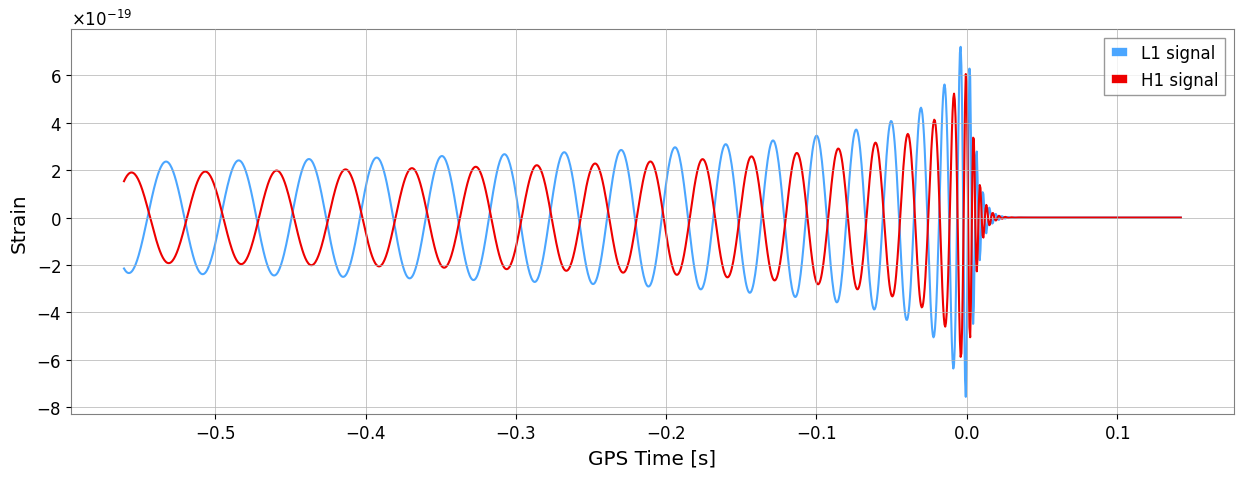

In [73]:
plt.figure(figsize=(15,5))
for ifo,colour in zip(ifos,colours):
    plt.plot(TimeSeries.from_pycbc(ht[ifo]),label='{} signal'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend()

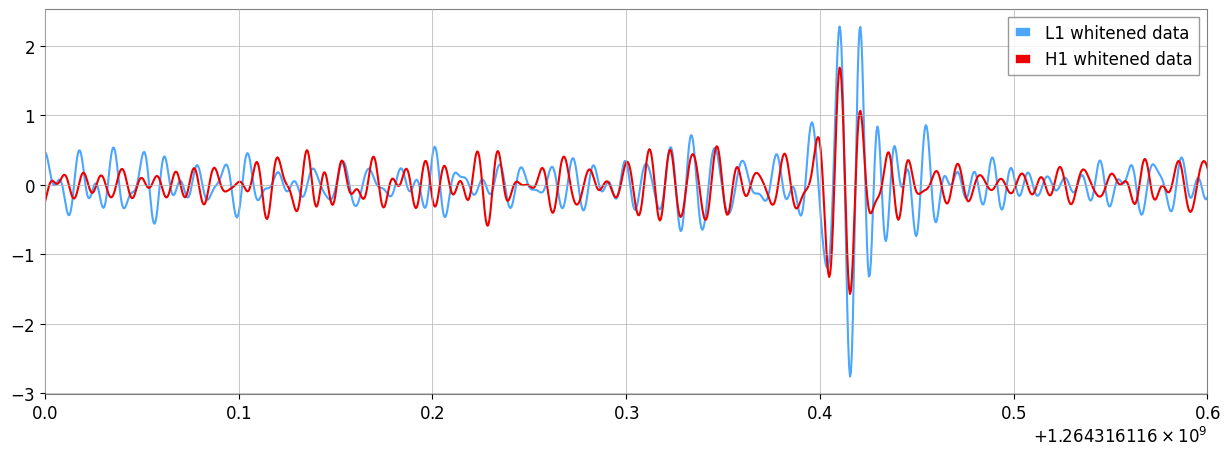

In [74]:
plt.figure(figsize=(15,5))
white_data={}
for ifo,colour in zip(ifos,colours):
    white_data[ifo]=data[ifo].whiten(fftlength=4).bandpass(60,120)
    plt.plot(white_data[ifo],label='{} whitened data'.format(ifo),color=colour)
#plt.xlim(time_centre-4, time_centre+5.3)
plt.xlim(time_centre-0.4, time_centre+0.2)
plt.legend()

In [75]:
time_delay=det['H1'].time_delay_from_earth_center(right_ascension, declination,time_centre)
print("For the sky-position ra={},dec={}, at time={},".format(right_ascension,declination,time_centre))
print("the time delay between Hanford and geocenter is {} seconds".format(time_delay))

For the sky-position ra=5.5,dec=0, at time=1264316116.4,
the time delay between Hanford and geocenter is 0.013537617427967502 seconds


Calculates the time delay between each detector.

As in chapter 7, we’ll make a light-weight wrapper for get_td_waveform() that will take parameter
vector⃗ 𝜆 and generate a waveform for us with the same sampling rate and time window as our data.
However, this time we need to project the “plus” and “cross” polarisations onto the detector arms

In [76]:
for ifo in ifos:
    data[ifo]=data[ifo].crop(time_centre-2,time_centre+2)

In [77]:
def gen_template(param,
    delta_t=data['H1'].dt.value, # Assuming all IFOs have the same dt
    duration=data['H1'].duration.value, # Assuming all IFOs have the same duration !
    start_time=data['H1'].x0.value,# Assuming all IFOs have the same start time !
    f_lower=20.):
    m1, m2, distance, time, phase, right_ascension, declination, inclination,polarization = param

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                            mass1=m1,
                            mass2=m2,
                            distance=distance,
                            inclination=inclination,
                            coa_phase=phase,
                            delta_t=delta_t,
                            f_lower=f_lower)
  # Resize the signal buffer
    hp.resize(int(duration/delta_t))
    hc.resize(int(duration/delta_t))
    ht={}
    template={}
# compute the detectors responses and shift to the requested time
    for ifo in ifos:
        fp, fc = det[ifo].antenna_pattern(right_ascension, declination,polarization, time)
        ht[ifo] = fp * hp.copy() + fc * hc.copy()
        time_delay = det[ifo].time_delay_from_earth_center(right_ascension,declination, time)
        ht[ifo] = ht[ifo].cyclic_time_shift(ht[ifo].start_time + time - start_time + time_delay)
        ht[ifo].start_time=start_time
        template[ifo]=TimeSeries.from_pycbc(ht[ifo])
    return template

(1264316116.2, 1264316116.45)

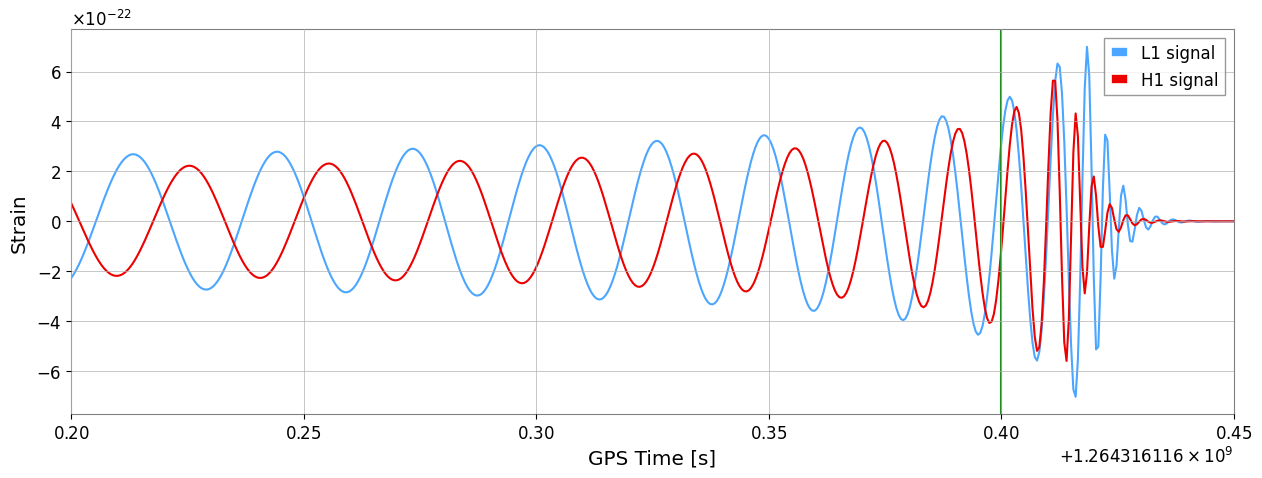

In [78]:
# Testing the gen_template() function:
param=[34.5,29,890,1264316116.4,0.0,5.5, 0, 0.0, 0.]
# m1, m2, distance, time, phase, right_ascension, declination, inclination,polarization = param
template=gen_template(param)
plt.figure(figsize=(15,5))
for ifo,colour in zip(ifos,colours):
  plt.plot(template[ifo],label='{} signal'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();
plt.axvline(time_centre,c='forestgreen')
plt.xlim([time_centre-0.2,time_centre+0.05])

Calculates the CBC model for each detector with parameters taken from the paper.

With the network waveform generator now defined, we can define our likelihood function, which is
equivalent to the product of single-detector likelihood functions

To construct a likelihood function for the GW detector network (the two LIGO instruments in this
case), we will make the very reasonable assumption that noise is independent between detectors.
This means that our network likelihood fuction is just the product of single-detector likelihood
functions

In [79]:
# FFT the data once, ahead of time
sf={}
for ifo in ifos:
    sf[ifo] = data[ifo].average_fft(window=('tukey',1./4.))*data[ifo].duration.value/2
def loglikelihood(param, sf=sf, f_lower=20.0):
    hf_hp = {}

    logl=0.0

    template = gen_template(param, delta_t=data['H1'].dt.value ,f_lower=f_lower)

    for ifo in ifos:
        # zero out the frequencies below f_lower
        sf_hp = sf[ifo].crop(start=f_lower)
        psd_hp = psd[ifo].crop(start=f_lower)

        hf = template[ifo].average_fft(window=('tukey',1./4.))*template[ifo].duration.value/2
        hf_hp = hf.crop(start=f_lower)

        h_dot_h = 4 * np.real((hf_hp * hf_hp.conjugate() / psd_hp).sum() *hf_hp.df)
        h_dot_s = 4 * np.real((sf_hp * hf_hp.conjugate() / psd_hp).sum() *sf_hp.df)

        logl += h_dot_s - h_dot_h/2
    return logl.value

-438.20232543784334


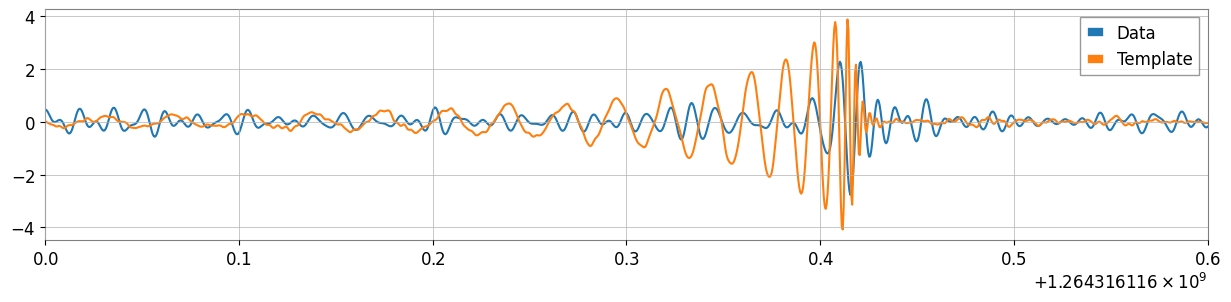

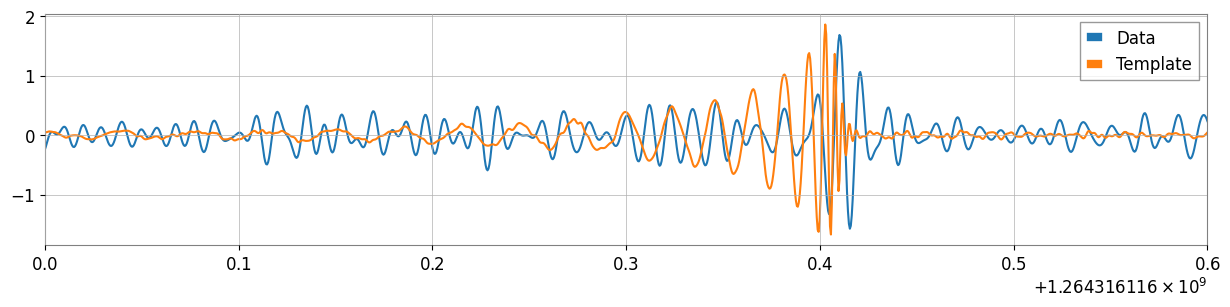

In [80]:
param0=[34.5,29,890,1264316116.4,0.0,0, 0.0, 0.0, 0.]
# m1, m2, distance, time, phase, right_ascension, declination, inclination,polarization = param

template0 = gen_template(param0)

for ifo in ifos:
    white_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

    plt.figure(figsize=[15, 3])
    plt.plot(white_data[ifo].times, white_data[ifo], label="Data")
    plt.plot(white_template.times, white_template, label="Template")
    plt.xlim(time_centre-0.4, time_centre+0.2)
    plt.legend();

print(loglikelihood(param0))

Now let’s maximize the likelihood to find the best-fit signal. We’ll use the minimize() function
provided by scipy using the Powell method, since it’s pretty good at dealing with non-smooth
functions. We’ll also define a callback function to print likelihood values and plot the model as it
works.

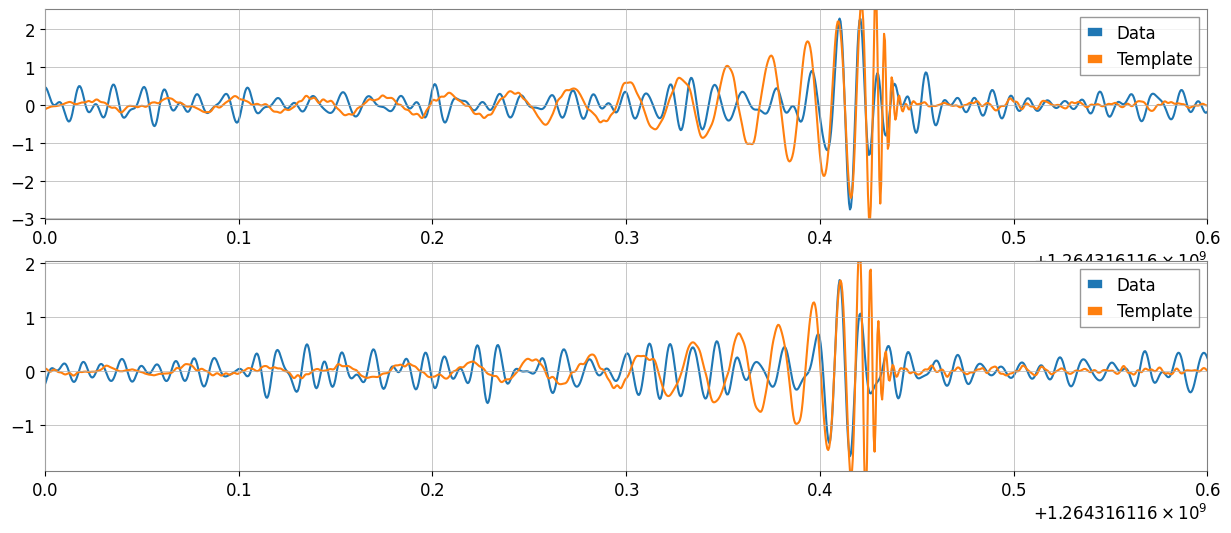

Steps	log(likelihood)
29	364.344


In [81]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, axs = plt.subplots(2, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo in zip(axs, ifos):
    hite_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

    ax.plot(white_data[ifo].times, white_data[ifo], label="Data")
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template")

    ax.set_xlim(time_centre-.4, time_centre+.2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(param_i)))

    Neval += 1

res = minimize(lambda param: -loglikelihood(param), param0, callback=callback, method='powell')
plt.close()


In [82]:
best_fit = res.x
best_fit_template = gen_template(best_fit) #best fit waveform found from optimisation of likelihood

Now let's subtract it from the data and see how consistent the residuals are with noise. We are using here the Q-transform to produce a high-resolution time-frequency map of the data:

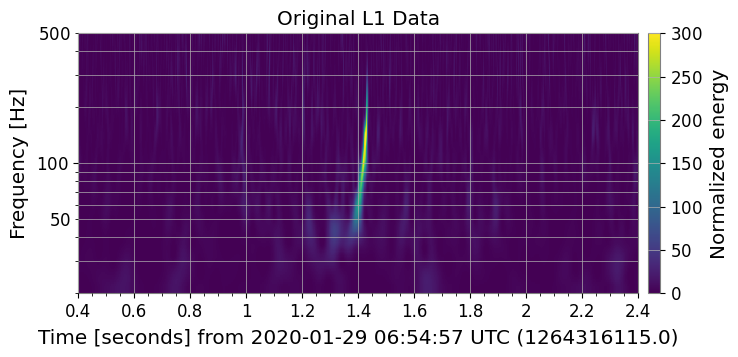

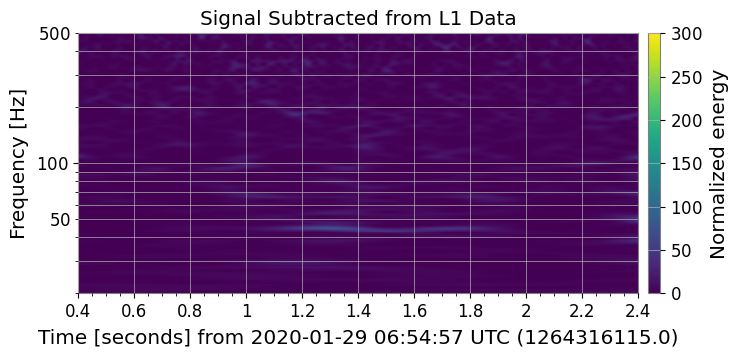

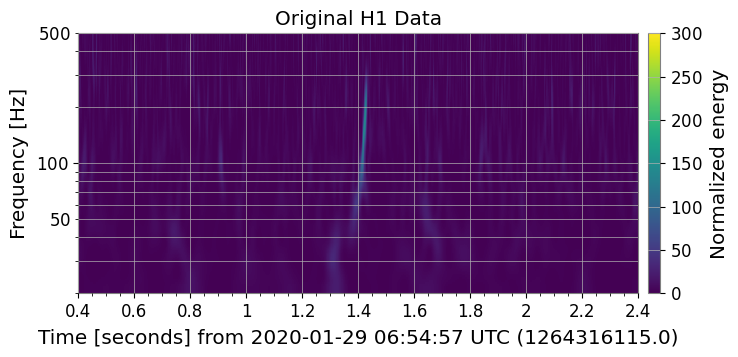

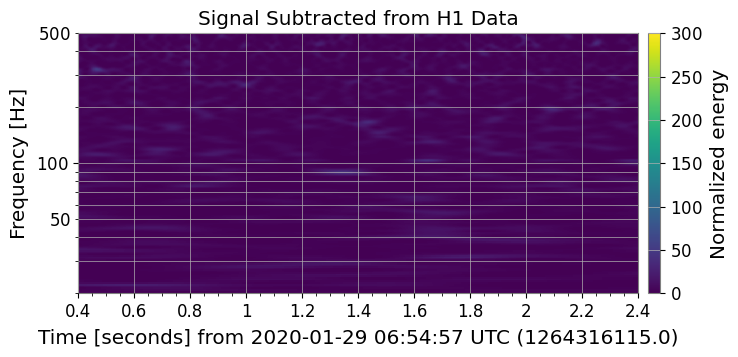

In [83]:
for i, ifo in enumerate(ifos):
    subtracted = data[ifo] - best_fit_template[ifo]

    # Plot the original data and the subtracted signal data
    for d, title in [(data[ifo], 'Original {} Data'.format(ifo)),
                 (subtracted, 'Signal Subtracted from {} Data'.format(ifo))]:

        qspecgram=d.whiten(asd=np.sqrt(psd[ifo])).q_transform(outseg=(time_centre - 1, time_centre + 1),
                                                     frange=(20, 512))

        plot = qspecgram.plot(figsize=[8, 4],vmin=0,vmax=300)
        ax = plot.gca()
        ax.set_title(title)
        ax.set_xscale('seconds')
        ax.set_yscale('log')
        ax.set_ylim(20, 500)
        ax.set_ylabel('Frequency [Hz]')
        ax.grid(True, axis='y', which='both')
        ax.colorbar(cmap='viridis', label='Normalized energy')

As you can see above the generated waveform is successful as the residual between the data and generated waveform appears to be negligable. This indicates that the match filtering was succesful. Furthermore, it shows the discrepency between SNR in the H1 and L1 detectors.

Now let's make a model without any known priors (from the paper). We will assume a uniform prior since we don't know anything about the signal in this case.

In [84]:
param0=[34.5,29,890,1264316116.4,0.0,0, 0.0, 0.001, 0.]

param=[34.5,29,890,1264316116.4,0.0,5.5, 0, 0.001, 0.]


In [85]:
def logprior(param):
    # Unpack parameters
    m1, m2, distance, time, phase, ra, dec, inclination, polarization = param

    # Enforce ordering of masses
    if m1 < m2 or m1 <= 5 or m2 <= 5:  # Ensure m1 >= m2 and reasonable limits
        return -np.inf

    # Apply Gaussian prior on masses (adjust mean & std as needed)
    mu_m1, sigma_m1 = 30, 15  # Mean and std for m1
    mu_m2, sigma_m2 = 20, 12  # Mean and std for m2
    logprior_m1 = -0.5 * ((m1 - mu_m1) / sigma_m1) ** 2
    logprior_m2 = -0.5 * ((m2 - mu_m2) / sigma_m2) ** 2

    # Apply inclination prior (sin distribution)
    logprior_inclination = np.log(np.sin(inclination)) if 0 < inclination < np.pi else -np.inf

    # Apply power-law prior for distance
    d_max = 5000  # Max reasonable distance in Mpc
    if distance > d_max or distance <= 0:
        return -np.inf
    logprior_distance = -((distance - d_max) / 500) ** 2 if distance > d_max else 0  # Smooth cutoff

    # Check valid ranges for angles
    for angle in [ra, phase, polarization]:
        if not (0 <= angle <= 2 * np.pi):
            return -np.inf

    if not (-np.pi / 2 <= dec <= np.pi / 2):
        return -np.inf

    # Sum all priors
    return logprior_m1 + logprior_m2 + logprior_inclination + logprior_distance


With network likelihood and prior defined we can now take their product to get the posterior.

In [86]:
def logposterior(param):
    logprior_val = logprior(param)

    # Reject invalid parameter values immediately
    if logprior_val == -np.inf:
        return -np.inf  # Reject sample

    loglikelihood_val = loglikelihood(param)

    # Check for NaNs in likelihood (e.g., numerical issues)
    if np.isnan(loglikelihood_val):
        return -np.inf

    return logprior_val + loglikelihood_val

In [87]:
logposterior(param0)

np.float64(-445.4358556763417)



We can now maximize the posterior to determine the maximum a posteriori (MAP) parameters.

Where the maximum likelihood point was the "best fit" in the sense that it found the parameters that produced a model most consistent with the data, the MAP is more of a "best guess" in that it balances fitting the data with being consistent with prior expectations for source parameters.

However, as the posterior is a density, the MAP does depend on the parametrisation we chose.


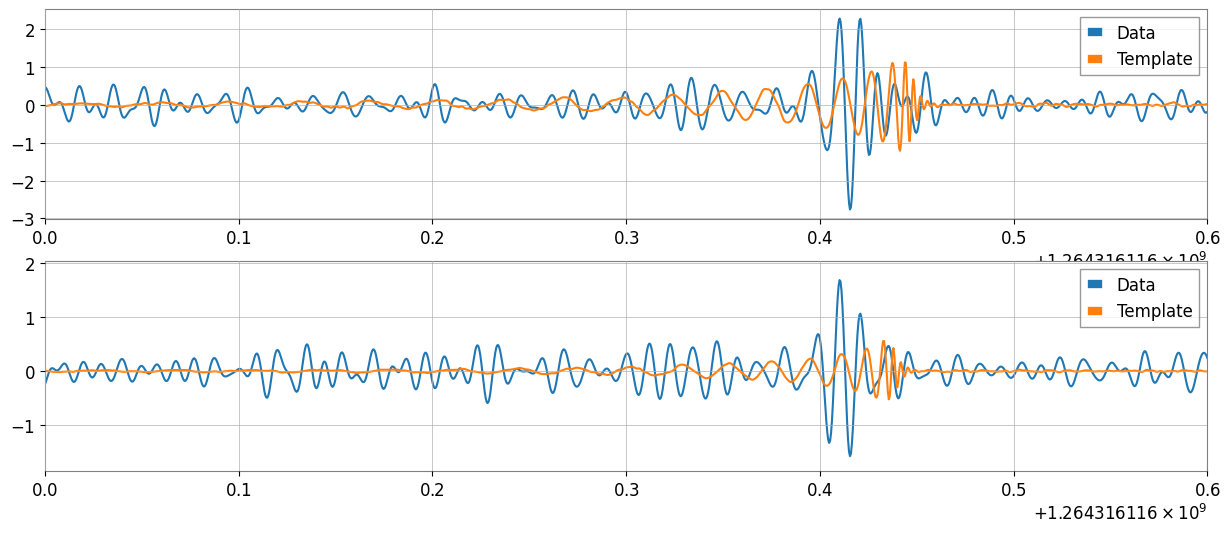

Steps	log(posterior)
20	43.217


In [88]:
from scipy.optimize import minimize
from IPython.display import display, clear_output


fig, axs = plt.subplots(2, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo in zip(axs, ifos):
    hite_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

    ax.plot(white_data[ifo].times, white_data[ifo], label="Data")
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template")

    ax.set_xlim(time_centre-.4, time_centre+.2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(posterior)")
    print('{}\t{:.3f}'.format(Neval, logposterior(param_i)))

    Neval += 1

res = minimize(lambda param: -logposterior(param), param0, callback=callback, method='powell')
plt.close()

In [89]:
best_guess = res.x
print(best_guess)

[ 3.45455344e+01  2.89874426e+01  1.91233434e+03  1.26431612e+09
  1.19741370e-01  1.44572366e-07 -5.02265417e-02  1.06171546e+00
  2.59049315e-08]


In [90]:
pip install emcee


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.6 MB/s eta 0:00:00


In [91]:
pip install corner

If you want to run a small test sample before committing to a full MCMC run, you can do the following: Key Adjustments for a Small Sample

Reduce the number of steps (nsteps): Instead of 2000, try 100 or 200 to test quickly.

Reduce the number of walkers (nwalkers): Instead of 3 * ndim, try 2 * ndim or even ndim + 1.

Run fewer burn-in steps: Since it's a test, use discard=50 instead of 1000.

Thin less aggressively: Instead of thin=10, use thin=2 so you don't discard too much data.

Print intermediate results to check progress

In [92]:

import emcee
import numpy as np
import matplotlib.pyplot as plt
import corner


# Number of dimensions (parameters)
ndim = len(param0)  # Assuming param0 is your initial guess

# Number of walkers (chains) - typically 2-3 times ndim
nwalkers = 2 * ndim

# Initialize walkers near the previous best-fit (add small noise)
p0 = [param0 + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)

# Run the MCMC chain
nsteps = 1000  # Increase if needed
sampler.run_mcmc(p0, nsteps, progress=True)

# Extract samples
samples = sampler.get_chain(discard=100, thin=5, flat=True)  # Burn-in & thinning


# Plot corner plot to visualize parameter distributions
fig = corner.corner(samples, labels=["m1", "m2", "distance", "time", "phase", "ra", "dec", "inc", "pol"])
plt.show()


  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2000/2000 [3:33:37<00:00,  6.41s/it]


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 9 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [170.39637097 222.61708869 164.206303   114.29643186
 242.33312959  49.93879351 142.56257697  92.75468627
 240.63811985]

Each diagonal plot in a corner plot shows the marginalized 1D posterior distribution for a parameter, while the rest shows the correlation between each parameter.

A corner plot for a detected binary black hole merger might show:

    M1,M2M1​,M2​ (component masses) → Highly correlated.

    χeffχeff​ (effective spin) → A broad posterior if spins are poorly constrained.

    dLdL​ (luminosity distance) vs. inclination → Shows an anti-correlation.

In [ ]:
samples = sampler.get_chain()

# Plot chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, ndim * 2), sharex=True)
labels = ["m1", "m2", "distance", "time", "phase", "ra", "dec", "inc", "pol"]

for i in range(ndim):
    axes[i].plot(samples[:, :, i], alpha=0.5)
    axes[i].set_ylabel(labels[i])

axes[-1].set_xlabel("Step number")
plt.show()

The above shows the parameter estimation performed by the MCMC. This method is a lengthier but more accurate way of parameter estimation than using optimisation. This is due to the fact that the MCMC effectively explores the entire parameter space through its random walk cycle, which gives it the ability to provide a full Baysian posterior distribution. This allows for computation of confidence intervals as opposed to the MAP provided by the optimiser, which is a single value instead of a distribution.

 Good (Converged) Trace Plot:

    Walkers mix well (i.e., they move up and down and explore the full range of the parameter space).

    No long-term trends (e.g., no drift toward higher or lower values).

    The chains settle into a stable region after an initial burn-in phase.

🔴 Bad (Non-Converged) Trace Plot:

    Chains are stuck in one region (poor mixing).

    Walkers show a strong drift over time.

    Large jumps between steps (suggests the step size might be too big).

    Some walkers are far from others, meaning different chains are exploring separate parts of parameter space (indicating poor sampling).

## Conclusions (15 points)
Minimum 300 words.
- Discuss your results in the context of the literature.
- Mention how your work compares with published results.
- Discuss some of the interpretation possibles of GW200129, including relevant citations from the literature, and summarising them.